# NN-VMC with self-attention wave function ansatz

In [ ]:
import time

import tqdm
import equinox as eqx
import jax


import jax.numpy as jnp
import numpy as np
import optax
import netket as nk
from jaxtyping import Array, PyTree, Float, Complex, PRNGKeyArray

import matplotlib.pyplot as plt

from models.slaternet import SlaterNet
from models.psi_solid import PsiSolid

from systems.continuous import moire
from utils.samplers.mcmc import metropolis_hastings_sampler


jax.config.update("jax_enable_x64", False)
key = jax.random.key(42)

\begin{equation}
    H=\sum_i\left(-\frac{1}{2}\nabla_i^2 + V(\mathbf r_i)\right) + \sum_{i < j}\frac{1}{|\mathbf r_i-\mathbf r_j|}
\end{equation}
- Moire potential:
\begin{equation}
    V(\mathbf r) = -2V_0\sum_{j=0}^2 \cos(\mathbf g_j\cdot\mathbf r + \varphi)
\end{equation}
Where $\mathbf g_j=\frac{4\pi}{\sqrt{3}a_M}\left(\cos\frac{2\pi j}{3},\sin\frac{2\pi j}{3}\right)$.

- Units
  - mass: Electron mass, $m_e$
  - Length: Effective Bohr radius, $a_0^* = \epsilon\dfrac{m_e}{m^*} a_0$
  - Energy: Effective Hartree, $\mathrm{Ha}^* = \dfrac{1}{\epsilon^2}\dfrac{m^*}{m_e}\mathrm{Ha}$

## System paramerters

In [2]:
# system parameters
a_0 = 5.291_772_105_44e-11 # m
m_e = 9.109_383_7139e-31 # kg
Ha = 4.359_744_722_2060e-18 # J = kg m^2/s^2
meV = 1.60218e-22 # J = kg m^2/s^2
nm = 1e-9 # m


epsilon = 5
# epsilon = 10
m_eff = 0.35 * m_e
a_B_eff = epsilon * (m_e / m_eff) * a_0
Ha_eff = (1 / (epsilon ** 2)) * (m_eff / m_e) * Ha


V0 = 15 * meV / Ha_eff
a_M = 8.031 * nm / a_B_eff
varphi = jnp.pi / 4
(V0, a_M, varphi)

(0.0393743564807352, 10.623473362015782, 0.7853981633974483)

In [3]:
primitive_latt_vects = a_M * jnp.array([
    [jnp.cos(-jnp.pi / 2), jnp.sin(-jnp.pi / 2)],
    [jnp.cos(jnp.pi / 6), jnp.sin(jnp.pi / 6)]
]) # [a_0, a_1]

primitive_recip_latt_vects = ((4 * jnp.pi) / (jnp.sqrt(3) * a_M)) * jnp.array([
    [jnp.cos(-jnp.pi / 3), jnp.sin(-jnp.pi / 3)],
    [jnp.cos(0), jnp.sin(0)]
]) # [b_0, b_1]
# a_i \cdot b_j = 2 \pi \delta_{ij}

(min1, max1) = (-2, 2)
(min2, max2) = (-2, 2)

(minu, maxu) = (min1 + 1/2, max1 + 1/2)
(minv, maxv) = (min2 + 1/2, max2 + 1/2)

N_elec = 16

# parametrization:
u, v = 0.1234, 1.1245
R = u * primitive_latt_vects[0] + v * primitive_latt_vects[1]
def indicator(x):
    u = jnp.dot(primitive_recip_latt_vects[0], x) / (2 * jnp.pi)
    v = jnp.dot(primitive_recip_latt_vects[1], x) / (2 * jnp.pi)
    return (minu <= u) & (u <= maxu) & (minv <= v) & (v <= maxv)

@jax.jit
def N_dim_indicator(R):
    projs = R @ primitive_recip_latt_vects.T        # (N, 2)
    uv    = projs / (2 * jnp.pi)                    # (N, 2)

    mask = (
        (minu <= uv[:, 0]) & (uv[:, 0] <= maxu) &
        (minv <= uv[:, 1]) & (uv[:, 1] <= maxv)
    )
    return jnp.all(mask)

# super cell: L_x := (max1 - min1) by L_y := (max2 - min2) cell, L_x L_y atoms)
from math import ceil
Nx = ceil(max1 - min1)
Ny = ceil(max2 - min2)
G = jnp.stack([
    primitive_recip_latt_vects[0] / Nx,
    primitive_recip_latt_vects[1] / Ny,
])

## Initializing Models

In [4]:
subkey, key = jax.random.split(key)

slater_log_psi = SlaterNet(
    num_particle=N_elec, 
    recip_latt_vecs=G, 
    hidden_dim=64,
    mlp_depth=8,
    key=subkey,
)

In [5]:
subkey, key = jax.random.split(key)

psi_solid_log_psi = PsiSolid(
    num_particle=N_elec, 
    recip_latt_vecs=G, 
    hidden_dim=64,
    intermediate_dim=64,
    attention_dim=16,
    num_heads=6,
    num_blocks=3, 
    num_mlp_layers=2,
    num_det=4,
    key=subkey,
)

## Samplers

In [6]:
subkey, key = jax.random.split(key)
R0 = jax.random.normal(subkey, (N_elec, 2))
slater_log_psi(R0), psi_solid_log_psi(R0)

(Array(-91.0450159+0.6905001j, dtype=complex128),
 Array(-85.93395108+0.64159083j, dtype=complex128))

elapsed time: 37.61 s
acceptance rate = 45.34 %
(65536, 16, 2)


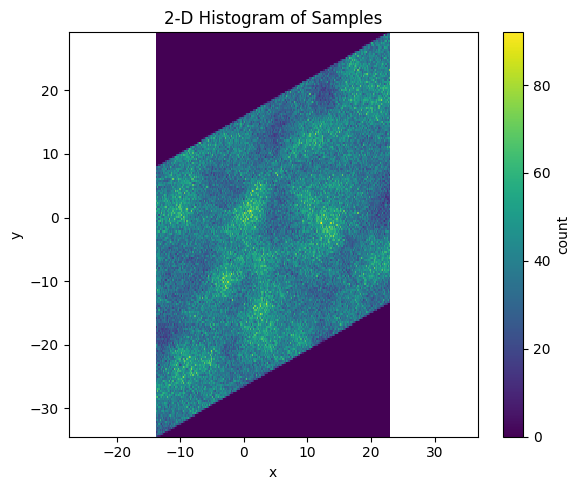

In [7]:
n_chains = 512

u_key, v_key, key = jax.random.split(key, 3)

u = jax.random.uniform(u_key, (n_chains, N_elec,), minval=minu, maxval=maxu)
v = jax.random.uniform(v_key, (n_chains, N_elec,), minval=minv, maxval=maxv)
uv = jnp.stack([u, v], axis=-1)

X0 = jnp.einsum("cni,id->cnd", uv, primitive_latt_vects)

subkey, key = jax.random.split(key)

start = time.time()
samples, acc_rate, mcmc_state = metropolis_hastings_sampler(
    key=subkey,
    initial_points=X0,
    log_psi_module=slater_log_psi,
    indicator_fn=N_dim_indicator,
    n_target_samples=65536,
    n_chains=n_chains,
    n_burn_in_per_chain=1024,
    thinning=4,
    sigma=0.5
)
samples.block_until_ready()
elapsed = time.time() - start
print(f"elapsed time: {elapsed:.2f} s")

X0 = mcmc_state.points
print(f"acceptance rate = {acc_rate.item() * 100:.2f} %")
print(f"{samples.shape}")

points = samples.reshape(-1, 2)

plt.figure(figsize=(6, 5))
plt.hist2d(
    points[:, 0],   # x 축
    points[:, 1],   # y 축
    bins=200,             # 격자 수(원하는 해상도로 조정)
    density=False         # 빈도수 그대로 볼 때 False, 확률밀도로 보려면 True
)
plt.colorbar(label='count')  # 각 칸의 샘플 개수 표시
plt.xlabel('x')
plt.ylabel('y')
plt.title('2-D Histogram of Samples')
plt.tight_layout()
plt.axis('equal')
plt.show()

## Train loop

In [8]:
def train(
    log_psi_fn: eqx.Module,
    optim: optax.GradientTransformation,
    X0: Float[Array, "n_chn n_par spc_dim"],
    steps: int,
    batch_size: int,
    n_chains: int,
    thinning: int,
    in_step_burnin: int,
    prop_sigma: float,
    key: PRNGKeyArray
):
    opt_state = optim.init(eqx.filter(log_psi_fn, eqx.is_array))

    energies = np.zeros(steps)
    gradnorms = np.zeros(steps)
    acceptance_rates = np.zeros(steps)
    
    @eqx.filter_jit
    def make_step(
        log_psi_fn: eqx.Module,
        opt_state: PyTree,
        samples: Float[Array, "b n_par spc_dim"],
    ):
        # local energy
        E_locs = jax.vmap(moire.local_energy,
                          in_axes=(None, 0, None, None, None))(
            log_psi_fn, samples, V0, a_M, varphi
        ) # (batch,)
        
        # grad_log_psi_square
        def grad_log_psi_conj(log_psi_fn, x):
            trainables, statics = eqx.partition(log_psi_fn, eqx.is_inexact_array)
            def f(trainables, x):
                _log_psi_fn = eqx.combine(trainables, statics)
                return _log_psi_fn(x).conj()
            return nk.jax.grad(f)(trainables, x)
        
        grad_log_psi_conjs = jax.vmap(grad_log_psi_conj, in_axes=(None, 0))(log_psi_fn, samples)
        
        # batch mean
        E_mean = jnp.mean(E_locs)
        grad_log_psi_conjs_mean = jax.tree_util.tree_map(lambda g: jnp.mean(g, axis=0), grad_log_psi_conjs)
        
        # covariance
        def vmc_cov(g, g_mean):
            centered_g = g - g_mean
            return 2 * jnp.real(jnp.einsum('b,b...->...', centered_E, centered_g) / batch_size)
        
        centered_E = E_locs - E_mean
        grads = jax.tree_util.tree_map(vmc_cov, grad_log_psi_conjs, grad_log_psi_conjs_mean)
        
        updates, opt_state = optim.update(
            eqx.filter(grads, eqx.is_array), opt_state, eqx.filter(log_psi_fn, eqx.is_array)
        )
        log_psi_fn = eqx.apply_updates(log_psi_fn, updates)
        
        grad_norm = jnp.sqrt(sum(jnp.sum(jnp.square(g)) for g in jax.tree_util.tree_leaves(grads)))
        return log_psi_fn, opt_state, jnp.real(E_mean), grad_norm
    
    pbar = tqdm.trange(steps, desc="training", unit="step")
    for step in pbar:
        key, subkey = jax.random.split(key)
        
        # MCMC sampling
        start = time.time()
        samples, acc_rate, state = metropolis_hastings_sampler(
            key=subkey,
            initial_points=X0,
            log_psi_module=psi_solid_log_psi,
            indicator_fn=N_dim_indicator,
            n_target_samples=batch_size,
            n_chains=n_chains,
            n_burn_in_per_chain=in_step_burnin,
            thinning=thinning,
            sigma=prop_sigma
        )
        X0 = state.points
        elapsed = time.time() - start
        print(f"MCMC: {elapsed:.4f} sec, acceptance rate: {acc_rate.item() * 100:.2f} %")
        
        start = time.time()
        log_psi_fn, opt_state, energy, grad_norm = make_step(log_psi_fn, opt_state, samples)
        elapsed = time.time() - start
        print(f"grad eval & update: {elapsed:.4f} sec")
        
        energies[step] = float(energy)
        gradnorms[step] = float(grad_norm)
        acceptance_rates[step] = float(acc_rate)
        
        pbar.set_postfix(energy=float(energy), gradnorm=float(grad_norm), mh_acc=float(acc_rate))
    
    return log_psi_fn, energies, gradnorms, acceptance_rates

In [9]:
def count_parameters(model):
    leaves = jax.tree.leaves(model)
    return sum(x.size for x in leaves if isinstance(x, jnp.ndarray))

count_parameters(psi_solid_log_psi), count_parameters(slater_log_psi)

(106744, 35588)

In [ ]:
n_batches = 1024
n_chains = 64
n_steps = 20 # 1536
start_learning_rate = 1e-3
optim = optax.adam(start_learning_rate)
log_psi_module = slater_log_psi


# params for mcmc
thinning = 3
in_step_burnin = 4
prop_sigma = 0.5

# burnin
u_key, v_key, key = jax.random.split(key, 3)

u = jax.random.uniform(u_key, (n_chains, N_elec,), minval=minu, maxval=maxu)
v = jax.random.uniform(v_key, (n_chains, N_elec,), minval=minv, maxval=maxv)
uv = jnp.stack([u, v], axis=-1)

X0 = jnp.einsum("cni,id->cnd", uv, primitive_latt_vects)

subkey, key = jax.random.split(key)

start = time.time()
samples, acc_rate, mcmc_state = metropolis_hastings_sampler(
    key=subkey,
    initial_points=X0,
    log_psi_module=log_psi_module,
    indicator_fn=N_dim_indicator,
    n_target_samples=n_chains,
    n_chains=n_chains,
    n_burn_in_per_chain=1024,
    thinning=0,
    sigma=0.5
)
X0 = mcmc_state.points
X0.block_until_ready()
elapsed = time.time() - start
print(f"burnin_compete: {elapsed:.2f} s")



key, subkey = jax.random.split(key, 2)

wave_fn, energies, gradnorms, acceptance_rates = train(
    log_psi_module, optim, X0, n_steps, n_batches, 
    n_chains, thinning, in_step_burnin, prop_sigma,
    subkey
)

burnin_compete: 4.16 s


training:   0%|          | 0/20 [00:00<?, ?step/s]

MCMC: 0.5181 sec, acceptance rate: 47.75 %


training:   5%|▌         | 1/20 [00:17<05:23, 17.04s/step, energy=8.45, gradnorm=32.7, mh_acc=0.478]

grad eval & update: 16.5179 sec
MCMC: 0.5302 sec, acceptance rate: 44.40 %


training:  10%|█         | 2/20 [00:31<04:37, 15.42s/step, energy=8.54, gradnorm=44.9, mh_acc=0.444]

grad eval & update: 13.7518 sec
MCMC: 0.5245 sec, acceptance rate: 44.27 %


training:  15%|█▌        | 3/20 [00:45<04:15, 15.01s/step, energy=8.46, gradnorm=32.3, mh_acc=0.443]

grad eval & update: 14.0046 sec
MCMC: 0.5068 sec, acceptance rate: 46.19 %


training:  20%|██        | 4/20 [01:02<04:07, 15.50s/step, energy=8.54, gradnorm=23.8, mh_acc=0.462]

grad eval & update: 15.7228 sec
MCMC: 0.7182 sec, acceptance rate: 44.21 %


training:  25%|██▌       | 5/20 [01:18<03:56, 15.80s/step, energy=8.42, gradnorm=20.9, mh_acc=0.442]

grad eval & update: 15.6170 sec
MCMC: 0.5232 sec, acceptance rate: 44.27 %


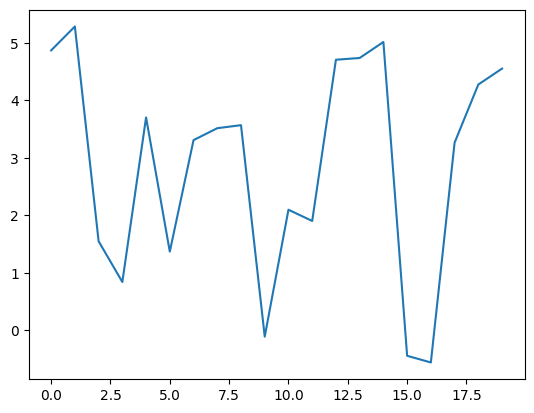

In [ ]:
plt.plot(energies)
plt.show()

In [ ]:
print(*energies)

4.867273792115553 5.2830162788648245 1.5483882227983836 0.8395152253305798 3.7009820878014805 1.3677137031841422 3.3065055985430423 3.5138496277786837 3.5666622899298566 -0.1113113497716911 2.0963631791786246 1.9005615642015106 4.70468689366737 4.735089988565732 5.01351761359676 -0.44400691945358917 -0.5604566578984185 3.2619713741265306 4.273643521291936 4.550564831889043
